## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Processing data

In [2]:
df = pd.read_csv("resale_data.csv")
# df.info()

In [3]:
# Datetime conversion
df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

# Convert remaining lease to better format
def lease_to_years(s):
    if pd.isna(s):
        return np.nan
    
    s = str(s).lower()
    
    years = re.search(r"(\d+)\s*year", s)
    months = re.search(r"(\d+)\s*month", s)
    
    y = int(years.group(1)) if years else 0
    m = int(months.group(1)) if months else 0
    
    return y + m/12

df["remaining_lease_years"] = df["remaining_lease"].apply(lease_to_years)

## Baseline Linear Regression

Gives me an idea on how a linear regression model performs when predicting resale flat prices

In [4]:
df["log_price"] = np.log(df["resale_price"])

#features
X = df[["town","flat_type","storey_range","floor_area_sqm", "remaining_lease_years","flat_model"]].copy()

#predictors
y = df[["log_price"]]

cat_cols = ["town","flat_type","storey_range"]
num_cols = ["floor_area_sqm", "remaining_lease_years"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[("preprocess", preprocess),("regressor", LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.168386424188229
RMSE: 0.19974124894350948


## Baseline model

What are the main drivers of price using simple OLS regression

In [5]:
model = smf.ols(
    "log_price ~ floor_area_sqm + C(flat_type) + remaining_lease_years",
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                 2.416e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:49:21   Log-Likelihood:                -11006.
No. Observations:              223415   AIC:                         2.203e+04
Df Residuals:                  223406   BIC:                         2.212e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Simple interpretation

A 2-room flat is associated with a 0.0991 higher log(price) than a 1-room flat (the baseline category), holding all other variables constant. OR
A 2-room flat is associated with about 10.4% higher resale price compared to a 1-room flat, holding other variables constant.

## Model + all other factors

Helps me understand if towns and other supporting features are significant predictors of price

In [6]:
model = smf.ols(
    "log_price ~ floor_area_sqm + C(town) + C(flat_type) + C(storey_range) + remaining_lease_years",
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     9119.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:49:23   Log-Likelihood:                 42103.
No. Observations:              223415   AIC:                        -8.411e+04
Df Residuals:                  223365   BIC:                        -8.359e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## XGBoost

In [7]:
from xgboost import XGBRegressor

In [8]:
xgb_model = Pipeline([("preprocess",preprocess),("regressor",XGBRegressor(
        n_estimators=2000,
        learning_rate=0.2,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42))])

xgb_model.fit(X_train,y_train)
pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("XGB MAE:", mae)
print("XGB RMSE:", rmse)

# XGB MAE: 0.08536281436681747
# XGB RMSE: 0.11549495475166903

XGB MAE: 0.08536281436681747
XGB RMSE: 0.11549495475166903


Compared to linear regression, the XGBoost model reduced the typical prediction error from ~18% to ~9%, and reduced large mistakes from ~22% to ~12%.

In [9]:
sample = X_test.copy()
sample["actual_price"] = np.exp(y_test.values)
sample["pred_price"] = np.exp(pred)
sample["abs_error"] = abs(sample["actual_price"] - sample["pred_price"])
sample["pct_error"] = sample["abs_error"] / sample["actual_price"]

sample.head(10)


,town,flat_type,storey_range,floor_area_sqm,remaining_lease_years,flat_model,actual_price,pred_price,abs_error,pct_error
305,CENTRAL AREA,3 ROOM,16 TO 18,68.0,61.166667,Improved,470000.0,497164.06250,27164.06250,0.057796
203794,CHOA CHU KANG,EXECUTIVE,07 TO 09,149.0,69.833333,Apartment,848000.0,776451.56250,71548.43750,0.084373
19284,BUKIT PANJANG,EXECUTIVE,22 TO 24,127.0,84.416667,Premium Apartment,748000.0,764514.37500,16514.37500,0.022078
143595,ANG MO KIO,3 ROOM,01 TO 03,68.0,56.500000,New Generation,350000.0,354108.96875,4108.96875,0.011740
26786,BUKIT MERAH,5 ROOM,01 TO 03,115.0,86.500000,Improved,800800.0,766637.56250,34162.43750,0.042660
90650,CHOA CHU KANG,4 ROOM,10 TO 12,93.0,94.416667,Model A,458888.0,493646.65625,34758.65625,0.075745
73223,BEDOK,5 ROOM,01 TO 03,122.0,64.416667,Improved,510000.0,521738.50000,11738.50000,0.023017
166584,WOODLANDS,4 ROOM,07 TO 09,103.0,60.583333,Model A,475000.0,471599.65625,3400.34375,0.007159
186729,QUEENSTOWN,3 ROOM,19 TO 21,65.0,48.500000,Improved,515388.0,509103.00000,6285.00000,0.012195
190374,TAMPINES,4 ROOM,10 TO 12,91.0,60.250000,New Generation,555000.0,549424.75000,5575.25000,0.010045


## SHAP Explanation

We use SHAP since XGBoost is non-linear, cannot simply use coefficients like OLS. SHAP tells us the feature importance

In [10]:
import shap

# 1) pull out fitted steps
pre = xgb_model.named_steps["preprocess"]
reg = xgb_model.named_steps["regressor"]

# 2) transform features (same as training)
X_test_enc = pre.transform(X_test)

# 3) get feature names after encoding
feature_names = pre.get_feature_names_out()

# print(feature_names)

/Users/othniel/Documents/GitHub/hdb-resale-econometrics/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP Global explanation

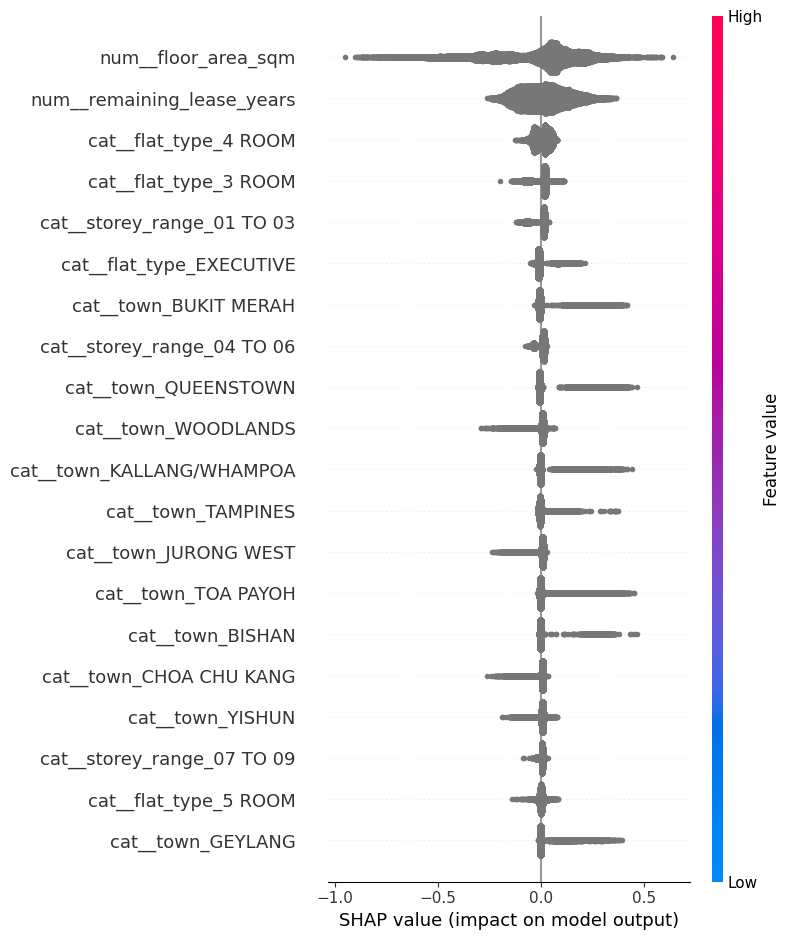

In [11]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test_enc)

shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names)

We now can undertsand the key drivers of predicted resale price.
The model is most sensitive to floor area and remaining lease. Larger flats and longer remaining leases consistently push predicted price higher. Storey range and flat type have secondary effects, and town captures location premiums.

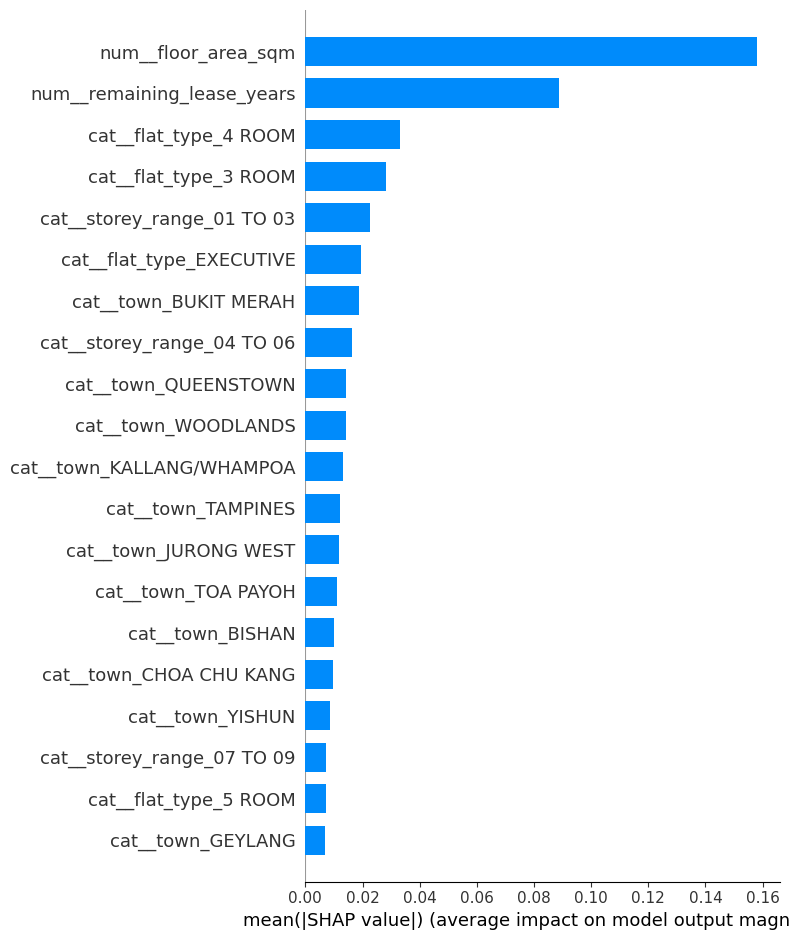

In [12]:
shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names, plot_type="bar")

SHAP Local explanation

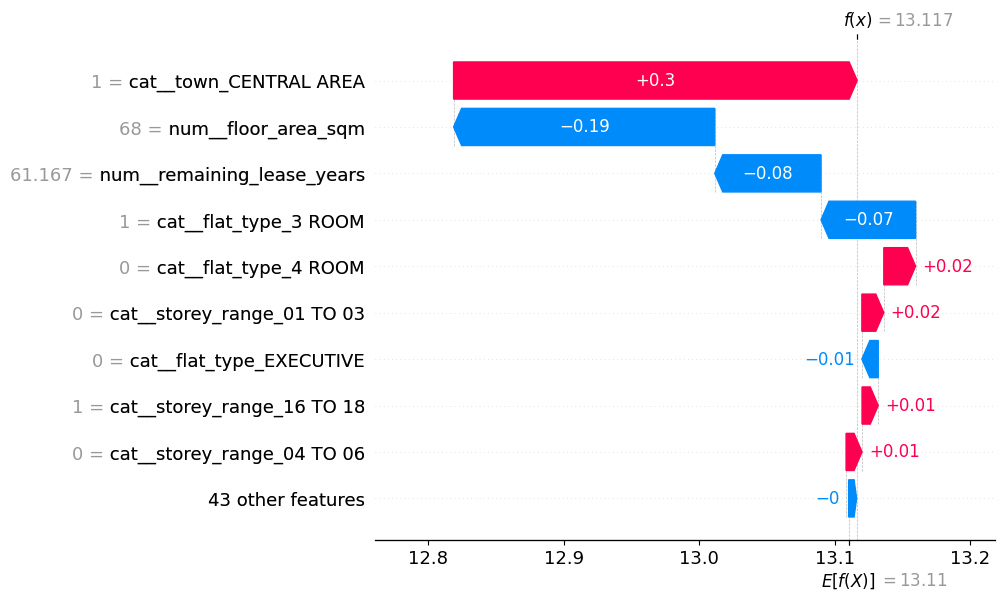

In [ ]:
i = 0  # choose any index

X_row = X_test_enc[i]
shap_row = shap_values[i]

x_dense = X_row.toarray()[0] if hasattr(X_row, "toarray") else X_row

shap.plots.waterfall(
    shap.Explanation(
        values=shap_row,
        base_values=explainer.expected_value,
        data=x_dense,
        feature_names=feature_names
    )
)


In [13]:
pred = xgb_model.predict((X_test))

actual_price = np.exp(y_test)
pred_price = np.exp(pred)

results = X_test.copy()

results["actual_price"] = actual_price
results["pred_price"] = pred_price

#To find out percentage difference
results["residual"] = results["actual_price"] - results["pred_price"]
results["abs_error"] = np.abs(results["residual"])
results["pct_error"] = results["abs_error"] / results["actual_price"]

In [ ]:
# Most undervalued flats
undervalued = results.sort_values("residual", ascending=True).head(20)
undervalued

,town,flat_type,storey_range,floor_area_sqm,remaining_lease_years,flat_model,actual_price,pred_price,residual,abs_error,pct_error
70985,BUKIT MERAH,5 ROOM,04 TO 06,115.0,79.250000,Improved,595000.0,9.992948e+05,-404294.7500,404294.7500,0.679487
68104,BUKIT BATOK,EXECUTIVE,16 TO 18,141.0,71.916667,Apartment,530000.0,9.305297e+05,-400529.6875,400529.6875,0.755716
77283,SERANGOON,4 ROOM,13 TO 15,111.0,64.083333,New Generation,402500.0,7.898034e+05,-387303.3750,387303.3750,0.962244
124119,CLEMENTI,5 ROOM,31 TO 33,113.0,94.500000,Improved,1060000.0,1.443334e+06,-383334.3750,383334.3750,0.361636
103626,TOA PAYOH,4 ROOM,10 TO 12,93.0,94.666667,Model A,700000.0,1.080421e+06,-380421.0000,380421.0000,0.543459
72141,SEMBAWANG,4 ROOM,04 TO 06,92.0,94.083333,Model A,378888.0,7.543101e+05,-375422.1250,375422.1250,0.990853
182512,KALLANG/WHAMPOA,3 ROOM,01 TO 03,92.0,47.333333,Terrace,700000.0,1.070739e+06,-370739.0000,370739.0000,0.529627
87455,WOODLANDS,EXECUTIVE,01 TO 03,186.0,63.833333,Apartment,670000.0,1.017855e+06,-347855.0625,347855.0625,0.519187
6660,GEYLANG,4 ROOM,07 TO 09,112.0,50.666667,Adjoined flat,490000.0,8.355776e+05,-345577.6250,345577.6250,0.705260
51733,SEMBAWANG,4 ROOM,01 TO 03,92.0,95.000000,Model A,325000.0,6.626076e+05,-337607.6250,337607.6250,1.038793


In [ ]:
# Most overpriced flats
overpriced = results.sort_values("residual", ascending=False).head(20)
overpriced

,town,flat_type,storey_range,floor_area_sqm,remaining_lease_years,flat_model,actual_price,pred_price,residual,abs_error,pct_error
206303,HOUGANG,EXECUTIVE,04 TO 06,148.0,65.916667,Maisonette,1450000.0,739128.81250,710871.18750,710871.18750,0.490256
170788,BEDOK,5 ROOM,07 TO 09,126.0,63.750000,Improved,1050000.0,532518.18750,517481.81250,517481.81250,0.492840
169663,ANG MO KIO,5 ROOM,07 TO 09,134.0,53.666667,Adjoined flat,1260000.0,761676.18750,498323.81250,498323.81250,0.395495
222864,QUEENSTOWN,4 ROOM,19 TO 21,95.0,89.333333,Premium Apartment Loft,1258000.0,793037.50000,464962.50000,464962.50000,0.369605
199450,BISHAN,5 ROOM,07 TO 09,121.0,66.250000,Improved,1225000.0,769489.81250,455510.18750,455510.18750,0.371845
222444,CLEMENTI,4 ROOM,40 TO 42,93.0,94.500000,Model A,1350000.0,917063.00000,432937.00000,432937.00000,0.320694
213944,SENGKANG,4 ROOM,01 TO 03,90.0,82.916667,Premium Apartment,800000.0,378487.68750,421512.31250,421512.31250,0.526890
201677,BUKIT MERAH,5 ROOM,16 TO 18,114.0,86.666667,Improved,1408888.0,993971.18750,414916.81250,414916.81250,0.294500
119064,BEDOK,5 ROOM,13 TO 15,121.0,65.250000,Improved,915000.0,502424.21875,412575.78125,412575.78125,0.450902
213930,SENGKANG,4 ROOM,04 TO 06,90.0,83.083333,Premium Apartment,815000.0,403400.93750,411599.06250,411599.06250,0.505030


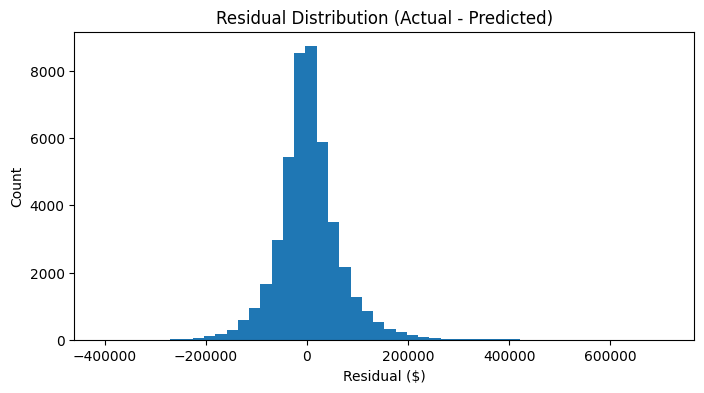

In [16]:
plt.figure(figsize=(8,4))
plt.hist(results["residual"], bins=50)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual ($)")
plt.ylabel("Count")
plt.show()


## Calculating Prediction Interval

In [ ]:
pred_log = np.asarray(pred, dtype=float).ravel()

y_true_log = np.asarray(y_test.squeeze(), dtype=float).ravel()

residuals = y_true_log - pred_log
low_q, high_q = np.quantile(residuals, [0.05, 0.95])
print("90% interval residual bounds (log space):")
print(low_q, high_q)

90% interval residual bounds (log space):
-0.1873225351154984 0.18907763364988664


In [18]:
import joblib

joblib.dump(xgb_model, "hdb_xgb_pipeline.pkl")
joblib.dump(X.columns.tolist(), "feature_cols.pkl")
joblib.dump((low_q, high_q), "pi_bounds.pkl")

['pi_bounds.pkl']